In [2]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely
import supervision as sv
import sklearn
import torch
import torchvision
import torchvision.transforms as transforms
import PIL

# **Datasets**

## **The dataset Dataset_for_YOLO was initially downloaded from the link provided by the mentor. Native Image chips and native labels were taken from the folder. The images were converted to the .jpeg format from .tif format and the duplicate copies were removed as a part of Data Cleaning.**
## **The Dataset_for_AP50 has 10 downloded images converted to 100 x 100 px dimensions and annotated using CVAT.ai to create a ground truth box and a prediction box each of 20 x 20 px size.**

# **Data Exploration and Understanding**

In [3]:
img_dir='/kaggle/input/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/images'
label_dir='/kaggle/input/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/labels'

## **1. Dataset statistics**

### **a. How many instances of solar panels are present in the dataset**

### **b. Compute and show the value counts of labels per image. E.g., X images have 0 labels, Y images have 1 label, … and so on.**


In [4]:
total_count = 0
file_no=0
obj_inst_dict={}

In [5]:
for label_file in os.listdir(label_dir):
    file_path = os.path.join(label_dir, label_file)
    with open(file_path, 'r', encoding='latin-1') as file:
        obj_count=0
        for line in file:
            obj_count+=1
            total_count+=1;
        file_no+=1 

        if obj_count in obj_inst_dict:
            obj_inst_dict[obj_count]=obj_inst_dict[obj_count]+1
        else:
            obj_inst_dict[obj_count]=1

In [6]:
total_img=0
total_inst_count=0
df = pd.DataFrame(columns=['Instances per image','No. of such images'])
index=0

for key, values in obj_inst_dict.items():
    df.loc[index]=[key,values]
    index+=1
    total_img+=values
    total_inst_count+=(key*values)
    print(f'{values} images have {key} solar-panels per image.')
print(f'There are {total_count} solar panel instances in {total_img} images.')
    
df.loc[index]=[f'Total Instances:{total_inst_count}',f'Total Images:{total_img}' ]

7 images have 32 solar-panels per image.
221 images have 3 solar-panels per image.
218 images have 4 solar-panels per image.
36 images have 17 solar-panels per image.
217 images have 5 solar-panels per image.
25 images have 18 solar-panels per image.
49 images have 14 solar-panels per image.
169 images have 9 solar-panels per image.
97 images have 11 solar-panels per image.
81 images have 1 solar-panels per image.
189 images have 6 solar-panels per image.
19 images have 34 solar-panels per image.
6 images have 36 solar-panels per image.
14 images have 20 solar-panels per image.
121 images have 10 solar-panels per image.
170 images have 7 solar-panels per image.
5 images have 74 solar-panels per image.
167 images have 2 solar-panels per image.
84 images have 12 solar-panels per image.
41 images have 16 solar-panels per image.
1 images have 75 solar-panels per image.
184 images have 8 solar-panels per image.
13 images have 38 solar-panels per image.
4 images have 66 solar-panels per imag

In [7]:
print(df)

      Instances per image No. of such images
0                      32                  7
1                       3                221
2                       4                218
3                      17                 36
4                       5                217
..                    ...                ...
70                     78                  1
71                     73                  1
72                     67                  1
73                     22                  1
74  Total Instances:29625  Total Images:2542

[75 rows x 2 columns]


In [78]:
labels_pth='/kaggle/input/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/labels'
class_0=[]
class_1=[]
class_2=[]

classes=[]
for label_file in os.listdir(labels_pth):
    with open(os.path.join(labels_pth,label_file), 'r') as file:
        class_id=0
        for line in file:
            class_id=line.split()[0]
            if class_id not in classes:
                classes.append(class_id)
        if class_id=='0':
            class_0.append(line)
        if class_id=='1':
                class_1.append(line)
        if class_id=='2':
            class_2.append(line)

print(f'The list of distinct classes: {classes}')
print(f'No. of Images with Class-0: {len(class_0)}')
print(f'No. of Images with Class-1: {len(class_1)}')
print(f'No. of Images with Class-2: {len(class_2)}')


The list of distinct classes: ['0', '2', '1']
No. of Images with Class-0: 2468
No. of Images with Class-1: 30
No. of Images with Class-2: 44


### **Answer:**
### **a. There are 29625 solar panel instances in 2542 images.**
### **b. Check previous code cells' outputs for imagewise instances**

### **The list of distinct classes: ['0', '2', '1']**
### **No. of Images with Class-0: 2468**
### **No. of Images with Class-1: 30**
### **No. of Images with Class-2: 44**

## **2. Calculate the statistics of the area of solar panels in meters (Read label readme carefully for this question)**

### **a. What method was used to compute the area (in meters) for a single instance?**
### **Answer:**
### **For a single instance(each line in a label(.txt) file represents an instance), its figures represent x_center, y_center, width and height respectively of the bounding box of that instance. Now, these coordinates are given in normalized form with respect to the pixel size of the image-chip taken. This image size is 416x416 according to the README file for Labels. Thus each coordinate is transformed back to its original pixel value by multiplying with 416. Also, these pixel values were actually scaled from metric units like meters. The scale factor can be obtained as 0.31 from coordinate system representation of each tile in the README file. Thus, further mutiplying the pixels by 0.31 results into metric values in meteres. Using the metric widths and heights of the bounding box, we get areas.**
### **width_in_m= width x 416 x 0.31**
### **height_in_m= height x 416 x 0.31**
### **Area= width x height**

### **b. What is the mean area and standard deviation?**


In [9]:
def get_area(x_val, y_val, px_size, scale_factor):
    x_px=x_val*px_size
    y_px=y_val*px_size
    x_len=scale_factor*x_px
    y_len=scale_factor*y_px

    return (x_len*y_len)

In [10]:
area_list=np.array([])

In [11]:
for label_file in os.listdir(label_dir):
    file_path = os.path.join(label_dir, label_file)
    with open(file_path, 'r', encoding='latin-1') as file:
        for line in file:
            category, x_center, y_center, x_width, y_width = line.split()
            x_center=float(x_center)
            y_center=float(y_center)
            x_width=float(x_width)
            y_width=float(y_width)
            area_list=np.append(area_list,get_area(x_width, y_width, px_size=416, scale_factor=0.31))
print(area_list[:20])

[  9.61   136.462  622.728  622.5358 630.416   38.7283  76.1112 139.2489
 219.8768 327.701  181.629  510.4832 186.8184 505.9665 533.1628 344.4224
 415.152  299.832  401.8902 306.8473]


In [12]:
mean_area=np.sum(area_list)/len(area_list)
print(mean_area)

191.51782786497895


In [13]:
std_dev_area=np.sqrt(np.sum(np.power((area_list-mean_area),2))/len(area_list))
print(std_dev_area)

630.7003355500087


### **Answer:**
### **The mean of all the areas is 191.51782786497895 sq. units and standard deviation is 630.7003355500087. sq. units**

### **c. Plot the histogram of areas. What do you observe?**

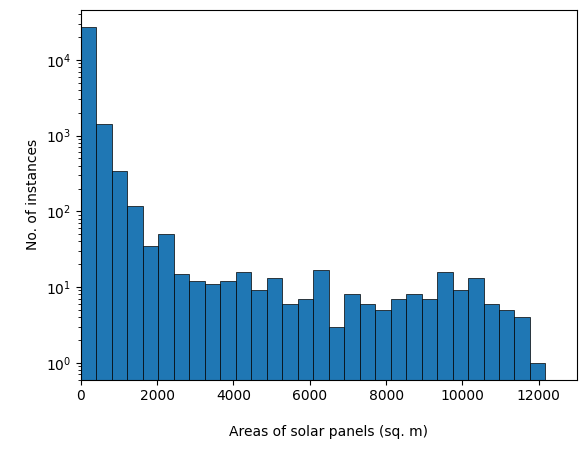

In [14]:
fig, ax = plt.subplots()
ax.hist(area_list, bins=30, log=True, linewidth=0.5,edgecolor='black')
ax.set(xlim=(0, 13000))
plt.xlabel(f'\nAreas of solar panels (sq. m)')
plt.ylabel(f'\nNo. of instances')
plt.show()

### **Answer:**
### **Above is the histogram of all the areas. We observe that no. of solar panels with areas <2000 sq. m is higher as it is convenient for many households and small commercial centres. On the other hand, the solar panels with higher areas like >6000 sq. m is relatively very less. This might be the represetation of industrial units which use solar power. Their no. is evidently very less compared to residential units.**

# **Implementing the Fundamental Functions**

## **1. Write a function to compute IoU (Intersection over Union) https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/ between two axis-aligned bounding boxes specified in the Ultralytics YOLO format. You MUST use the shapely library [https://pypi.org/project/shapely/] and its functionalities to write your function. Show that your function provides the same or similar answer as IoU computed using `supervision` library.**

In [15]:
def get_coords(label, px_size=1, scale_factor=1):
    class_id, x_center, y_center, width, height=label
    x_val=(x_center*px_size)*scale_factor
    y_val=(y_center*px_size)*scale_factor
    width=(width*px_size)*scale_factor
    height=(height*px_size)*scale_factor
    x_min=x_val-(width/2)
    x_max=x_val+(width/2)
    y_min=y_val-(height/2)
    y_max=y_val+(height/2)

    return x_min, y_min, x_max, y_max
    

In [16]:
from shapely.geometry import Polygon

In [17]:
def get_shapely_iou(gt_bbox_coords, pred_bbox_coords):
    x_min_gt, y_min_gt, x_max_gt, y_max_gt=gt_bbox_coords
    x_min_pred, y_min_pred, x_max_pred, y_max_pred=pred_bbox_coords
    gt_polygon=Polygon([(x_min_gt,y_min_gt),(x_max_gt, y_min_gt),(x_max_gt, y_max_gt),(x_min_gt, y_max_gt)])
    pred_polygon=Polygon([(x_min_pred,y_min_pred),(x_max_pred, y_min_pred),(x_max_pred, y_max_pred),(x_min_pred, y_max_pred)])
    area_of_intersection=gt_polygon.intersection(pred_polygon).area
    area_of_union=gt_polygon.union(pred_polygon).area
    iou_shapely=area_of_intersection/area_of_union
    return iou_shapely

In [18]:
def get_supervision_iou(gt_bbox_coords, pred_bbox_coords):
    x_min_gt, y_min_gt, x_max_gt, y_max_gt=gt_bbox_coords
    x_min_pred, y_min_pred, x_max_pred, y_max_pred=pred_bbox_coords
    gt_coords=np.array([x_min_gt, y_min_gt, x_max_gt, y_max_gt]).reshape(1,-1)
    pred_coords=np.array([x_min_pred, y_min_pred, x_max_pred, y_max_pred]).reshape(1,-1)
    iou_sv=sv.box_iou_batch(gt_coords, pred_coords).item()
    return iou_sv

In [19]:
label_gt = (0, 0.5, 0.5, 0.2, 0.2)   
label_pred = (0, 0.6, 0.5, 0.2, 0.2)  

gt_bbox_coords= get_coords(label_gt, px_size=416, scale_factor=0.31)
pred_bbox_coords= get_coords(label_pred, px_size=416, scale_factor=0.31)

print(f"IoU from supervision library: {get_supervision_iou(gt_bbox_coords, pred_bbox_coords)}")
print(f"IoU from shapely library: {get_shapely_iou(gt_bbox_coords, pred_bbox_coords)}")

IoU from supervision library: 0.3333333333333333
IoU from shapely library: 0.3333333333333333


### **Answer: Both the methods give us Iou of around 0.333.**

## **2. Write a function to compute Average Precision (AP):**
### **a. Use Pascal VOC 11 point interpolation method to implement the function.**
### **b. Use COCO 101-point interpolation method to implement the function.**
### **c. Use Area under Precision-Recall Curve (AP) method to implement the function.** 
### **d. Randomly generate 10 images of size 100x100. Randomly generate 10 ground truth boxes of size 20x20 and 10 predicted boxes of size 20x20 in each image. Assume there is only one class of objects. Compare the AP50 (Average Precision at IoU 0.5) computed by 3 of your methods**

### **Answer:** 

### **Path to randomly taken and processed images (to 100 x 100 px size) along with YOLO-annotations generated using CVAT.ai:** 

In [20]:
img_pth_ap50='/kaggle/input/datasets-for-object-detection-task/Datasets/Dataset_for_AP50/images_for_AP50'
labels_pth_ap50='/kaggle/input/datasets-for-object-detection-task/Datasets/Dataset_for_AP50/labels_for_AP50'

### **Function to generate Ground Triths and Predictions:** 

In [21]:
def get_gts_preds(img_pth, label_pth):
    gt_list=[]
    pred_list=[]
    np.random.seed(42)
    n=len(os.listdir(label_pth))
    confidence_scores=np.random.uniform(0,1,n)
    index=0
    for label_file in os.listdir(label_pth):
        file_path = os.path.join(label_pth, label_file)
        lines=[]
        with open(file_path, 'r', encoding='latin-1') as file:
            for line in file:
                lines.append(line)
                
            gt_class, gt_x_cen, gt_y_cen, gt_width, gt_height=lines[0].split()
            gt={}
            gt['image_id']=index+1
            gt['class_id']=int(gt_class)
            gt['bbox']=get_coords((gt_class, float(gt_x_cen), float(gt_y_cen), float(gt_width), float(gt_height)))
            gt_list.append(gt)

            pred_class, pred_x_cen, pred_y_cen, pred_width, pred_height=lines[1].split()
            pred={}
            pred['class_id']=int(pred_class)
            pred['bbox']=get_coords((pred_class, float(pred_x_cen), float(pred_y_cen), float(pred_width), float(pred_height)))
            pred['confidence']=confidence_scores[index]
            pred_list.append(pred)
            
        index+=1
    return gt_list, pred_list

In [22]:
gts, preds=get_gts_preds(img_pth_ap50, labels_pth_ap50)

### **Function to calculate AP50 by PASCAL VOC 11-point interpolation method:** 

In [23]:
def ap50_by_pascal_voc_11(gts,preds):
    tp=0
    fp=0
    prec_recall_pairs=[]
    matched_gts=[]
    preds_sorted=sorted(preds, key=lambda x: x['confidence'], reverse=True)
    for pred in preds_sorted:
        precision=0
        recall=0
        iou_list=[]
        for gt in gts:
            iou_list.append(get_shapely_iou(gt['bbox'],pred['bbox']))
        max_iou=np.max(iou_list)
        matching_gt_idx=np.argmax(iou_list)
        matching_gt=gts[matching_gt_idx]
        if matching_gt not in matched_gts:
            matched_gts.append(matching_gt)
            if(max_iou>=0.5):
                tp+=1
            else:
                fp+=1
        else:
            fp+=1
        precision=tp/(tp+fp)
        recall=tp/len(gts)
        prec_recall_pairs.append((precision,recall))

    recall_thresholds=np.linspace(0,1,11)
    interpolated_precs=[]
    for recall_th in recall_thresholds:
        interpolated_prec=0
        for prec,rec in prec_recall_pairs:
            if rec>=recall_th:
                interpolated_prec=max(interpolated_prec,prec)
        interpolated_precs.append(interpolated_prec)
    avg_prec=np.mean(interpolated_precs)
    return avg_prec

### **Function to calculate AP50 by COCO 101-point interpolation method:** 

In [25]:
def ap50_by_coco_101(gts,preds):
    tp=0
    fp=0
    prec_recall_pairs=[]
    matched_gts=[]
    preds_sorted=sorted(preds, key=lambda x: x['confidence'], reverse=True)
    for pred in preds_sorted:
        precision=0
        recall=0
        iou_list=[]
        for gt in gts:
            iou_list.append(get_shapely_iou(gt['bbox'],pred['bbox']))
        max_iou=np.max(iou_list)
        matching_gt_idx=np.argmax(iou_list)
        matching_gt=gts[matching_gt_idx]
        if matching_gt not in matched_gts:
            matched_gts.append(matching_gt)
            if(max_iou>=0.5):
                tp+=1
            else:
                fp+=1
        else:
            fp+=1
        precision=tp/(tp+fp)
        recall=tp/len(gts)
        prec_recall_pairs.append((precision,recall))

    recall_thresholds=np.linspace(0,1,101)
    interpolated_precs=[]
    for recall_th in recall_thresholds:
        interpolated_prec=0
        for prec,rec in prec_recall_pairs:
            if rec>=recall_th:
                interpolated_prec=max(interpolated_prec,prec)
        interpolated_precs.append(interpolated_prec)
    avg_prec=np.mean(interpolated_precs)
    return avg_prec

### **Function to calculate AP50 by AUC-PR curve method:** 

In [27]:
from sklearn.metrics import precision_recall_curve, auc

In [28]:
def ap50_by_auc_pr(gts,preds):
    y_true=[]
    y_pred_confid_scrs=[]
    matched_gts=[]
    for pred in preds:
        iou_list=[]
        for gt in gts:
            iou_list.append(get_shapely_iou(gt['bbox'],pred['bbox']))
        max_iou=np.max(iou_list)
        matching_gt_idx=np.argmax(iou_list)
        matching_gt=gts[matching_gt_idx]
        if matching_gt not in matched_gts:
            matched_gts.append(matching_gt)
            if(max_iou>=0.5):
                y_true.append(1)
            else:
                y_true.append(0)
        else:
            y_true.append(0)
        y_pred_confid_scrs.append(pred['confidence'])
    precision, recall, _ = precision_recall_curve(y_true, y_pred_confid_scrs)
    ap50 = auc(recall, precision)
    return ap50    


### **AP50 by all 3 methods:** 

In [24]:
ap50_by_pascal_voc_11(gts,preds)

0.22727272727272727

In [26]:
ap50_by_coco_101(gts,preds)

0.1914191419141914

In [29]:
ap50_by_auc_pr(gts,preds)

0.5694444444444444

### **The AP50 calculated is: 0.22727272727272727 by PASCAL VOC 11 point interpolation method, 0.1914191419141914 by COCO 101 point interpolation and 0.5694444444444444 by Area-Under-PR-Curve method. COCO 101 gives less AP50 that PASCAL VOC because it checks precision variation at 101 points as compared to only 11 points in PASCAL VOC, and thus taking into account more no. of variations in precisions. AUC-PR method gives best value as it integrates the entire P-R curve considering all precision values across all recall values.** 

# **Model building and evaluation**

## **Split the data into 80-20 train-test split. Use 10% of training data as validation.**

#### **Copying the dataset to working directory for train-test split.**

In [30]:
![ -d /kaggle/working/datasets-for-object-detection-task ] || cp -r /kaggle/input/datasets-for-object-detection-task /kaggle/working/

### **Function to create train-test split:**

In [31]:
def create_train_test_val_dirs(img_dir, label_dir, train_fraction, val_fraction):
    images=os.listdir(img_dir)
    np.random.seed(42)
    np.random.shuffle(images)
    train_len=int(train_fraction*len(images))
    train_imgs=images[:train_len] 
    test_imgs=images[train_len:]
    val_len=int(val_fraction*len(train_imgs))
    val_imgs=train_imgs[:val_len]  
    train_imgs=train_imgs[val_len:]

    labels=os.listdir(label_dir)
    train_labels=[]
    test_labels=[]
    val_labels=[]
    
    for label_name in labels:
        corresp_img=label_name.replace(".txt",".jpeg")
        if corresp_img in train_imgs:
            train_labels.append(label_name)
        elif corresp_img in test_imgs:
            test_labels.append(label_name)
        else:
            val_labels.append(label_name)

    train_imgs=np.sort(train_imgs)
    train_labels=np.sort(train_labels)
    test_imgs=np.sort(test_imgs)
    test_labels=np.sort(test_labels)
    val_imgs=np.sort(val_imgs)
    val_labels=np.sort(val_labels)
    
    train_img_dir=os.path.join(img_dir,'train')
    train_label_dir=os.path.join(label_dir,'train')
    test_img_dir=os.path.join(img_dir,'test')
    test_label_dir=os.path.join(label_dir,'test')
    val_img_dir=os.path.join(img_dir,'val')
    val_label_dir=os.path.join(label_dir,'val')

    folder_pths=[train_img_dir, train_label_dir, test_img_dir, test_label_dir, val_img_dir, val_label_dir]
    
    for folder_pth in folder_pths:
        os.makedirs(folder_pth, exist_ok=True)

    files_and_pths_list=[(train_imgs,img_dir,train_img_dir),(train_labels,label_dir,train_label_dir),(test_imgs,img_dir,test_img_dir),(test_labels,label_dir,test_label_dir),(val_imgs,img_dir,val_img_dir),(val_labels,label_dir,val_label_dir)]
    
    for files_list, src_fldr, dest_fldr in files_and_pths_list:
        for file in files_list:
            if os.path.exists(os.path.join(src_fldr, file)) and not os.path.exists(os.path.join(dest_fldr, file)):
                shutil.move(os.path.join(src_fldr, file), os.path.join(dest_fldr, file))

In [32]:
img_dir_pth='/kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/images'
label_dir_pth='/kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/labels'

In [33]:
create_train_test_val_dirs(img_dir_pth, label_dir_pth, 0.8, 0.1)

## **1. Use any model from Ultralytics like YOLO to train the object detection model. Show that validation loss is converged.**

### **Model Training: YOLOv8n**

In [34]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


#### **Creating data.yaml file.**

In [35]:
config_file_content = """path: /kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO
train: /kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/images/train
val: /kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/images/val
test: /kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/images/test

nc: 3
names: ["solar_panel_type1","solar_panel_type2","solar_panel_type3"]
"""
config_file_pth = "/kaggle/working/data.yaml"
if not os.path.exists(config_file_pth):
    with open(config_file_pth, "w") as file:
        file.write(config_file_content)

    print(f"data.yaml created at {config_file_pth}")

data.yaml created at /kaggle/working/data.yaml


#### **Training the model for 70 epochs:**

In [36]:
model=YOLO("yolov8n.pt")
model.train(data="/kaggle/working/data.yaml", epochs=70)

100%|██████████| 6.25M/6.25M [00:00<00:00, 85.3MB/s]


Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=70, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

100%|██████████| 755k/755k [00:00<00:00, 17.1MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 72.0MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/labels/train... 1830 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1830/1830 [00:01<00:00, 1092.15it/s]

train: New cache created: /kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/labels/val... 203 images, 0 backgrounds, 0 corrupt: 100%|██████████| 203/203 [00:00<00:00, 911.27it/s]

val: New cache created: /kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      3.13G       1.67      2.137      1.352         95        640: 100%|██████████| 115/115 [00:20<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        203       2314      0.868      0.189      0.178      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70       3.3G      1.374      1.195      1.156        109        640: 100%|██████████| 115/115 [00:18<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]

                   all        203       2314      0.934      0.224      0.257      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      3.35G      1.352      1.121      1.146         42        640: 100%|██████████| 115/115 [00:18<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]

                   all        203       2314      0.927      0.249      0.271      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70       2.8G      1.316      1.019      1.137        230        640: 100%|██████████| 115/115 [00:18<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.85it/s]

                   all        203       2314      0.943      0.261      0.294      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70       2.6G       1.24     0.9356      1.091        195        640: 100%|██████████| 115/115 [00:19<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]

                   all        203       2314      0.952      0.271      0.305      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      3.11G       1.22      0.886      1.076         94        640: 100%|██████████| 115/115 [00:19<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]

                   all        203       2314      0.954      0.266      0.342      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      2.96G      1.235     0.8852      1.083         83        640: 100%|██████████| 115/115 [00:19<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.02it/s]

                   all        203       2314      0.952      0.252      0.308      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      2.94G      1.198     0.8288       1.07         91        640: 100%|██████████| 115/115 [00:19<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.10it/s]

                   all        203       2314      0.958       0.28      0.415      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      3.35G      1.183      0.822      1.064        121        640: 100%|██████████| 115/115 [00:19<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]

                   all        203       2314      0.878      0.419      0.443      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      2.89G      1.148     0.7834       1.05         91        640: 100%|██████████| 115/115 [00:19<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

                   all        203       2314      0.805      0.354      0.373      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      2.88G      1.156     0.7717      1.049         46        640: 100%|██████████| 115/115 [00:19<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.98it/s]

                   all        203       2314      0.833      0.439      0.464      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      2.79G      1.135     0.7621      1.039        158        640: 100%|██████████| 115/115 [00:19<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.16it/s]

                   all        203       2314      0.847       0.42      0.496      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      2.96G      1.112     0.7335      1.029        114        640: 100%|██████████| 115/115 [00:19<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.19it/s]

                   all        203       2314      0.875      0.424      0.483      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      2.86G      1.123     0.7439      1.036        110        640: 100%|██████████| 115/115 [00:19<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.05it/s]

                   all        203       2314      0.872      0.452      0.506      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      2.95G      1.071     0.7086      1.021         99        640: 100%|██████████| 115/115 [00:19<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.32it/s]

                   all        203       2314       0.89      0.447      0.533      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      2.85G      1.072     0.6966      1.011        169        640: 100%|██████████| 115/115 [00:19<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.14it/s]

                   all        203       2314      0.556      0.531      0.503      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      2.36G      1.075     0.6799      1.014         59        640: 100%|██████████| 115/115 [00:19<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.09it/s]

                   all        203       2314      0.743      0.478      0.525      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      2.72G      1.041     0.6658      1.004         70        640: 100%|██████████| 115/115 [00:19<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.05it/s]

                   all        203       2314      0.874      0.505      0.572      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      3.36G      1.043     0.6613      1.001         94        640: 100%|██████████| 115/115 [00:19<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.20it/s]

                   all        203       2314      0.926      0.433      0.509      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70       2.9G      1.027      0.651     0.9903         77        640: 100%|██████████| 115/115 [00:19<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.29it/s]

                   all        203       2314      0.692      0.523      0.561      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      3.08G      1.008     0.6339     0.9866         78        640: 100%|██████████| 115/115 [00:19<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.28it/s]

                   all        203       2314      0.913      0.482      0.531      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      2.51G      1.011     0.6445     0.9948         74        640: 100%|██████████| 115/115 [00:19<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.10it/s]

                   all        203       2314      0.826      0.487      0.562      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      2.34G      1.015     0.6388     0.9915        232        640: 100%|██████████| 115/115 [00:19<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.13it/s]

                   all        203       2314      0.772      0.552      0.588      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      2.92G     0.9974     0.6232     0.9879         83        640: 100%|██████████| 115/115 [00:19<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.05it/s]

                   all        203       2314      0.768      0.554      0.573      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      2.68G     0.9928     0.6155     0.9765         95        640: 100%|██████████| 115/115 [00:19<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]

                   all        203       2314      0.707      0.559      0.618      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      2.78G     0.9732     0.6042     0.9778         96        640: 100%|██████████| 115/115 [00:19<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.27it/s]

                   all        203       2314       0.77      0.574      0.616      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      2.88G     0.9452     0.5909     0.9662         84        640: 100%|██████████| 115/115 [00:19<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.26it/s]

                   all        203       2314      0.846      0.539      0.703      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70       3.1G     0.9652     0.6019     0.9745         97        640: 100%|██████████| 115/115 [00:19<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.11it/s]

                   all        203       2314      0.835      0.564      0.656      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      3.23G     0.9464      0.589     0.9703         50        640: 100%|██████████| 115/115 [00:19<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]

                   all        203       2314      0.849      0.584      0.687      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      2.95G     0.9356     0.5814     0.9641        129        640: 100%|██████████| 115/115 [00:19<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]

                   all        203       2314      0.855      0.567      0.654      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      3.41G     0.9182     0.5648     0.9548         84        640: 100%|██████████| 115/115 [00:19<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.10it/s]

                   all        203       2314      0.824      0.615      0.698      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      2.94G     0.9164     0.5674     0.9573         97        640: 100%|██████████| 115/115 [00:19<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.17it/s]

                   all        203       2314      0.745      0.721      0.805       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      2.54G     0.9229     0.5671     0.9588         69        640: 100%|██████████| 115/115 [00:19<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.04it/s]

                   all        203       2314      0.794      0.612      0.766      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      2.76G     0.9179     0.5698     0.9629         62        640: 100%|██████████| 115/115 [00:19<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.32it/s]

                   all        203       2314      0.857      0.732      0.834      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      2.62G     0.8898     0.5459     0.9465         64        640: 100%|██████████| 115/115 [00:19<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.25it/s]

                   all        203       2314      0.897      0.677      0.781      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      3.03G     0.8793     0.5383     0.9429         61        640: 100%|██████████| 115/115 [00:19<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.06it/s]

                   all        203       2314      0.862      0.691      0.797      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70       3.2G     0.8672     0.5343     0.9413         47        640: 100%|██████████| 115/115 [00:19<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.28it/s]

                   all        203       2314      0.814      0.759       0.83      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70         3G     0.8628     0.5312     0.9387         48        640: 100%|██████████| 115/115 [00:19<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.15it/s]

                   all        203       2314      0.861      0.765      0.833      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      2.58G     0.8805     0.5442     0.9448        115        640: 100%|██████████| 115/115 [00:19<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]

                   all        203       2314      0.871      0.766      0.834      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      3.37G     0.8712      0.538     0.9444        121        640: 100%|██████████| 115/115 [00:19<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.24it/s]

                   all        203       2314      0.899      0.757      0.864      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      3.28G     0.8469      0.517     0.9341        148        640: 100%|██████████| 115/115 [00:19<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.48it/s]

                   all        203       2314      0.885       0.79       0.83      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      2.59G     0.8328     0.5155      0.935        131        640: 100%|██████████| 115/115 [00:19<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.02it/s]

                   all        203       2314      0.876      0.781      0.842      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      2.99G     0.8355     0.5145      0.933         76        640: 100%|██████████| 115/115 [00:19<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.32it/s]

                   all        203       2314      0.874      0.812      0.873       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      3.25G     0.8429     0.5153     0.9323        144        640: 100%|██████████| 115/115 [00:19<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.33it/s]

                   all        203       2314       0.92      0.849      0.909      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      2.69G     0.8253     0.5064     0.9284        119        640: 100%|██████████| 115/115 [00:19<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.04it/s]

                   all        203       2314      0.933      0.774      0.877      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      3.05G     0.8282      0.506     0.9307        118        640: 100%|██████████| 115/115 [00:19<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.21it/s]

                   all        203       2314      0.768      0.779      0.835      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      3.09G     0.7972      0.493      0.921        135        640: 100%|██████████| 115/115 [00:19<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.02it/s]

                   all        203       2314      0.944      0.807      0.898      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      2.77G     0.7918     0.4899     0.9199         90        640: 100%|██████████| 115/115 [00:19<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]

                   all        203       2314      0.901      0.846      0.926      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      2.69G     0.8116     0.4936     0.9249         98        640: 100%|██████████| 115/115 [00:19<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.29it/s]

                   all        203       2314      0.928      0.901      0.916      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      2.95G     0.7912     0.4884       0.92        111        640: 100%|██████████| 115/115 [00:19<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.17it/s]

                   all        203       2314       0.94      0.888      0.954      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      2.41G      0.772     0.4757      0.913         47        640: 100%|██████████| 115/115 [00:19<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.92it/s]

                   all        203       2314      0.896       0.88      0.908      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      3.02G     0.7809     0.4763     0.9156         91        640: 100%|██████████| 115/115 [00:19<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.26it/s]

                   all        203       2314      0.863      0.868      0.894      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      3.21G     0.7908     0.4817     0.9182        112        640: 100%|██████████| 115/115 [00:19<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]

                   all        203       2314      0.942      0.883      0.922       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      3.06G     0.7854     0.4799     0.9114         85        640: 100%|██████████| 115/115 [00:19<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]

                   all        203       2314      0.962      0.904      0.926      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      3.49G     0.7766     0.4769       0.91         89        640: 100%|██████████| 115/115 [00:19<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.35it/s]

                   all        203       2314      0.928       0.92       0.94      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      2.88G     0.7492      0.462     0.9053        176        640: 100%|██████████| 115/115 [00:19<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.34it/s]

                   all        203       2314      0.962      0.852      0.922      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70       3.5G     0.7543     0.4673     0.9073        165        640: 100%|██████████| 115/115 [00:19<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]

                   all        203       2314      0.945      0.921      0.935      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      2.86G     0.7493     0.4628     0.9082        123        640: 100%|██████████| 115/115 [00:19<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.32it/s]

                   all        203       2314      0.957      0.895      0.937      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      2.81G     0.7446     0.4592     0.9061         86        640: 100%|██████████| 115/115 [00:19<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.20it/s]

                   all        203       2314      0.934      0.876      0.929      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      2.69G     0.7351      0.458      0.905        195        640: 100%|██████████| 115/115 [00:19<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.92it/s]

                   all        203       2314      0.948      0.923      0.932      0.746


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      2.86G     0.6943     0.4199     0.8848         53        640: 100%|██████████| 115/115 [00:19<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.31it/s]

                   all        203       2314      0.954      0.868      0.915      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      2.78G      0.664     0.4064     0.8778         84        640: 100%|██████████| 115/115 [00:18<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.33it/s]

                   all        203       2314      0.988       0.92      0.943      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      2.54G     0.6527     0.3996     0.8732        100        640: 100%|██████████| 115/115 [00:18<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]

                   all        203       2314      0.978      0.918      0.964      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      2.91G      0.643     0.3961      0.871         80        640: 100%|██████████| 115/115 [00:18<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.17it/s]

                   all        203       2314      0.962      0.925      0.956      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      2.52G     0.6434     0.3934     0.8716        110        640: 100%|██████████| 115/115 [00:19<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.10it/s]

                   all        203       2314      0.952      0.918      0.937      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      2.59G     0.6321      0.391      0.869         38        640: 100%|██████████| 115/115 [00:18<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.21it/s]

                   all        203       2314      0.966      0.917      0.949      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      2.64G      0.635     0.3926     0.8671         47        640: 100%|██████████| 115/115 [00:18<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.06it/s]

                   all        203       2314      0.976      0.894      0.966      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      2.38G     0.6247     0.3866     0.8658         65        640: 100%|██████████| 115/115 [00:18<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.33it/s]

                   all        203       2314      0.952      0.921      0.974      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      3.02G     0.6187     0.3848     0.8686         68        640: 100%|██████████| 115/115 [00:18<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.11it/s]

                   all        203       2314      0.974      0.916      0.971      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      2.57G     0.6112     0.3803     0.8637         58        640: 100%|██████████| 115/115 [00:18<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.33it/s]

                   all        203       2314      0.973      0.916      0.972      0.802



70 epochs completed in 0.417 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


                   all        203       2314      0.991      0.907      0.967      0.807
     solar_panel_type1        201       2278      0.995      0.919      0.984      0.863
     solar_panel_type2          8         16      0.978      0.812      0.921      0.786
     solar_panel_type3         12         20          1      0.991      0.995      0.772


Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 9.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f9fc9d67700>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

#### **Plotting Validation Losses against epochs: Shows Convergence**

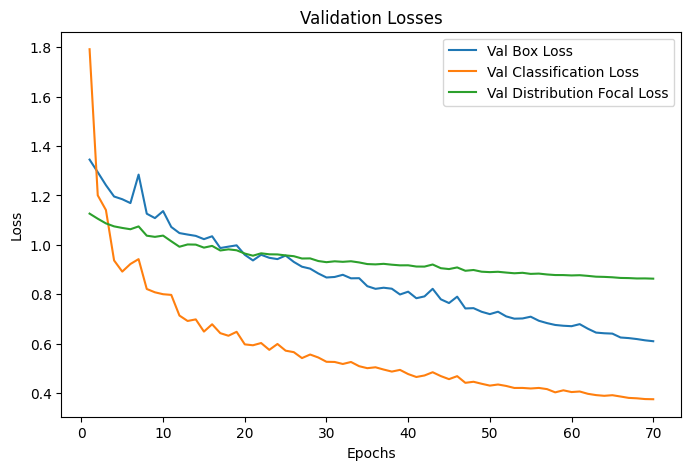

In [37]:
results_path="/kaggle/working/runs/detect/train/results.csv"  
results=pd.read_csv(results_path)

plt.figure(figsize=(8, 5))
plt.plot(results["epoch"], results["val/box_loss"], label="Val Box Loss")
plt.plot(results["epoch"], results["val/cls_loss"], label="Val Classification Loss")
plt.plot(results["epoch"], results["val/dfl_loss"], label="Val Distribution Focal Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Validation Losses")
plt.show()

#### **Making Predictions:**

In [38]:
model=YOLO("runs/detect/train/weights/best.pt")  
pred_results=model.predict("/kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/images/test", save=True)


image 1/509 /kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/images/test/solarpanels_native_1__x0_0_y0_6845_dxdy_416.jpeg: 640x640 9 solar_panel_type1s, 7.4ms
image 2/509 /kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/images/test/solarpanels_native_1__x0_0_y0_7230_dxdy_416.jpeg: 640x640 14 solar_panel_type1s, 1 solar_panel_type3, 7.3ms
image 3/509 /kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/images/test/solarpanels_native_1__x0_0_y0_7418_dxdy_416.jpeg: 640x640 7 solar_panel_type1s, 7.4ms
image 4/509 /kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/images/test/solarpanels_native_1__x0_10055_y0_11061_dxdy_416.jpeg: 640x640 8 solar_panel_type1s, 7.3ms
image 5/509 /kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/images/test/solarpanels_native_1__x0_10336_y0_10994_dxdy_416.jpeg: 640x640 4 solar_panel_type1s, 7.7ms
image 6/509 /kaggle/working/data

## **2. Predict solar panels using the trained model. Visualize the ground truth and predicted bounding boxes on 3-4 random samples from the test dataset. Use appropriate color schemes to differentiate between ground truth and predicted labels.**
**

In [39]:
def highlight_patch(image, x_min, y_min, x_max, y_max, color, thickness=2):
    copy_img = np.array(image)
    copy_img[y_min:y_min+thickness, x_min:x_max]=color  
    copy_img[y_max-thickness:y_max, x_min:x_max]=color  
    copy_img[y_min:y_max, x_min:x_min+thickness]=color  
    copy_img[y_min:y_max, x_max-thickness:x_max]=color  

    copy_img_tensor=torch.from_numpy(copy_img)

    return copy_img_tensor

In [40]:
from PIL import Image


image 1/1 /kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/images/test/solarpanels_native_3__x0_9637_y0_14691_dxdy_416.jpeg: 640x640 16 solar_panel_type1s, 6.3ms
Speed: 3.0ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


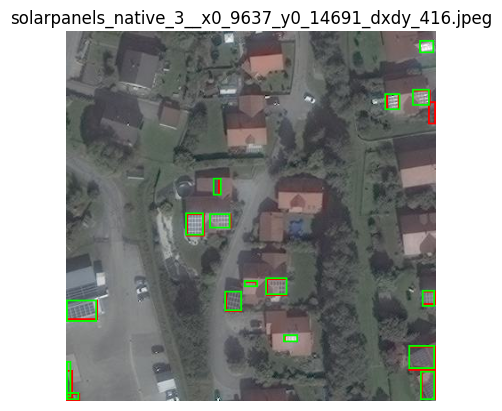


image 1/1 /kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/images/test/solarpanels_native_2__x0_2733_y0_5068_dxdy_416.jpeg: 640x640 36 solar_panel_type1s, 6.4ms
Speed: 2.5ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


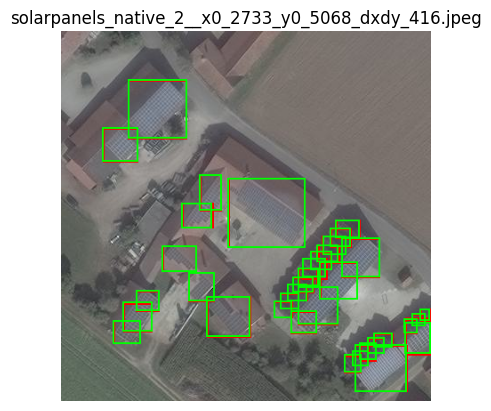


image 1/1 /kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/images/test/solarpanels_native_3__x0_10242_y0_6762_dxdy_416.jpeg: 640x640 3 solar_panel_type1s, 6.8ms
Speed: 2.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


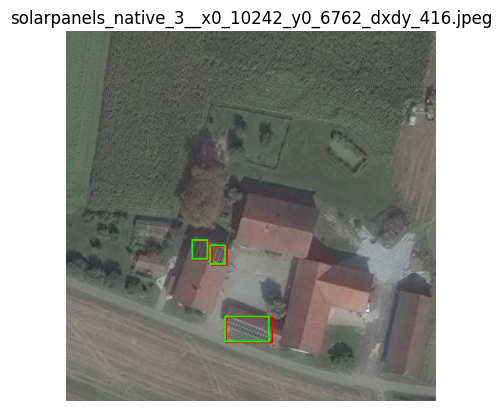


image 1/1 /kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/images/test/solarpanels_native_2__x0_3481_y0_11332_dxdy_416.jpeg: 640x640 2 solar_panel_type1s, 6.3ms
Speed: 2.4ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


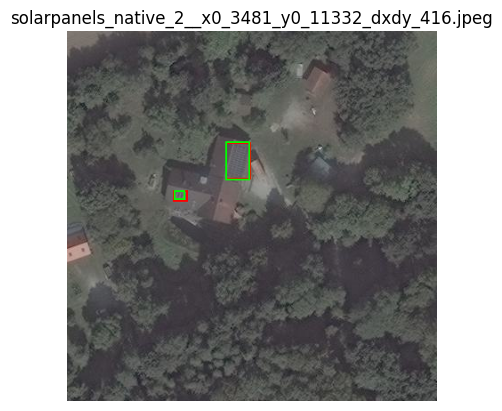

In [41]:
test_img_dir='/kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/images/test'
test_label_dir='/kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/labels/test'

np.random.seed(42)
test_samples=np.random.choice(os.listdir(test_img_dir),4)

for sample_img in test_samples:
    test_img_file=os.path.join(test_img_dir,sample_img)
    test_image = Image.open(test_img_file).convert("RGB")
    test_label_file=os.path.join(test_label_dir,sample_img.replace('.jpeg','.txt'))
    lines=[]
    with open(test_label_file, 'r', encoding='latin-1') as file:
        for line in file:
            lines.append(line)
        for line in lines:
            class_id, x_cen, y_cen, width, height=line.split()
            x_min, y_min, x_max, y_max=get_coords((class_id, float(x_cen), float(y_cen), float(width), float(height)),px_size=416)
            test_image=highlight_patch(test_image, int(x_min), int(y_min), int(x_max), int(y_max), color=np.array([255, 0, 0]))

    results=model(test_img_file)
    for result in results:
        for bbox in result.boxes.xyxy:
            x_min_pred=bbox[0]
            y_min_pred=bbox[1]
            x_max_pred=bbox[2]
            y_max_pred=bbox[3]
            test_image=highlight_patch(test_image, int(x_min_pred), int(y_min_pred), int(x_max_pred), int(y_max_pred), color=np.array([0, 255, 0]))
    
    plt.imshow(test_image.numpy())
    plt.title(sample_img)
    plt.axis("off")
    plt.show()

## **Use supervision.metrics functionality from supervision library to compute the following metrics.**
### **a. Compute mAP50 with supervision and compare with your implementation. What do you observe?**

In [42]:
from supervision.metrics import MeanAveragePrecision

In [43]:
model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

dataset=sv.DetectionDataset.from_yolo(
    images_directory_path='/kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/images/test',
    annotations_directory_path='/kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/labels/test',
    data_yaml_path='/kaggle/working/data.yaml'
)

def callback(image: np.ndarray) -> sv.Detections:
    result = model(image)[0]  
    return sv.Detections.from_ultralytics(result) 

mean_average_precision = sv.MeanAveragePrecision.benchmark(
    dataset=dataset, 
    callback=callback  
)

print(f"mAP@0.5: {mean_average_precision.map50}")


0: 640x640 10 solar_panel_type1s, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 solar_panel_type1s, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 20 solar_panel_type1s, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 solar_panel_type1s, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 solar_panel_type1s, 1 solar_panel_type2, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 solar_panel_type1s, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 solar_panel_type1s, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 43 solar_pan

### **Answer: The mAP@0.5 is 0.933.**

### **Create a table of Precision, Recall and F1-scores where rows are IoU thresholds [0.1, 0.3, 0.5, 0.7, 0.9] and columns are confidence thresholds [0.1, 0.3, 0.5, 0.7, 0.9] (Hint use supervision.metrics.ConfusionMatrix to get the confusion matrix and get TP, FP and FN from it to compute the P, R and F-1)**

In [ ]:
iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
conf_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

model=YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

dataset=sv.DetectionDataset.from_yolo(
    images_directory_path='/kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/images/test',
    annotations_directory_path='/kaggle/working/datasets-for-object-detection-task/Datasets/Dataset_for_YOLO/labels/test',
    data_yaml_path='/kaggle/working/data.yaml'
)

def callback(image: np.ndarray) -> sv.Detections:
    result=model(image)[0]  
    return sv.Detections.from_ultralytics(result)

index_labels=[f"iou={iou}" for iou in iou_thresholds]
column_labels=[f"conf={conf}" for conf in conf_thresholds]
df=pd.DataFrame(index=index_labels, columns=column_labels)

for i, iou_thresh in enumerate(iou_thresholds):
    for j, conf_thresh in enumerate(conf_thresholds):
        confusion_matrix = sv.ConfusionMatrix.benchmark(
            dataset=dataset,
            callback=callback,
            iou_threshold=iou_thresh,
            conf_threshold=conf_thresh
            )

        conf_matrix=confusion_matrix.matrix
        num_classes=len(conf_matrix)-1  
        TP=np.diag(conf_matrix)[:num_classes] 
        FP=conf_matrix[-1, :num_classes] 
        FN=conf_matrix[:num_classes, -1] 

        micro_TP=np.sum(TP)
        micro_FP=np.sum(FP)
        micro_FN=np.sum(FN)
        
        micro_precision=micro_TP/(micro_TP+micro_FP)
        micro_recall=micro_TP/(micro_TP+micro_FN)
        micro_f1=2*(micro_precision*micro_recall)/(micro_precision+micro_recall)


        cell_value=f'P:{micro_precision:.3f} R:{micro_recall:.3f} F1:{micro_f1:.3f}'
        df.iloc[i, j]=cell_value


0: 640x640 10 solar_panel_type1s, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 solar_panel_type1s, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 20 solar_panel_type1s, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 solar_panel_type1s, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 solar_panel_type1s, 1 solar_panel_type2, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 solar_panel_type1s, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 solar_panel_type1s, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 43 solar_pan

In [81]:
df

,conf=0.1,conf=0.3,conf=0.5,conf=0.7,conf=0.9
iou=0.1,P:0.935 R:0.972 F1:0.953,P:0.944 R:0.970 F1:0.957,P:0.978 R:0.956 F1:0.967,P:0.995 R:0.911 F1:0.951,P:1.000 R:0.388 F1:0.559
iou=0.3,P:0.935 R:0.971 F1:0.953,P:0.943 R:0.970 F1:0.956,P:0.978 R:0.956 F1:0.967,P:0.995 R:0.911 F1:0.951,P:1.000 R:0.388 F1:0.559
iou=0.5,P:0.933 R:0.970 F1:0.951,P:0.942 R:0.968 F1:0.955,P:0.978 R:0.956 F1:0.967,P:0.995 R:0.911 F1:0.951,P:1.000 R:0.388 F1:0.559
iou=0.7,P:0.918 R:0.953 F1:0.935,P:0.926 R:0.952 F1:0.939,P:0.963 R:0.942 F1:0.953,P:0.986 R:0.902 F1:0.942,P:0.999 R:0.388 F1:0.559
iou=0.9,P:0.658 R:0.683 F1:0.670,P:0.665 R:0.683 F1:0.674,P:0.697 R:0.681 F1:0.689,P:0.736 R:0.673 F1:0.703,P:0.943 R:0.366 F1:0.527


In [82]:
print(df)

                         conf=0.1                  conf=0.3  \
iou=0.1  P:0.935 R:0.972 F1:0.953  P:0.944 R:0.970 F1:0.957   
iou=0.3  P:0.935 R:0.971 F1:0.953  P:0.943 R:0.970 F1:0.956   
iou=0.5  P:0.933 R:0.970 F1:0.951  P:0.942 R:0.968 F1:0.955   
iou=0.7  P:0.918 R:0.953 F1:0.935  P:0.926 R:0.952 F1:0.939   
iou=0.9  P:0.658 R:0.683 F1:0.670  P:0.665 R:0.683 F1:0.674   

                         conf=0.5                  conf=0.7  \
iou=0.1  P:0.978 R:0.956 F1:0.967  P:0.995 R:0.911 F1:0.951   
iou=0.3  P:0.978 R:0.956 F1:0.967  P:0.995 R:0.911 F1:0.951   
iou=0.5  P:0.978 R:0.956 F1:0.967  P:0.995 R:0.911 F1:0.951   
iou=0.7  P:0.963 R:0.942 F1:0.953  P:0.986 R:0.902 F1:0.942   
iou=0.9  P:0.697 R:0.681 F1:0.689  P:0.736 R:0.673 F1:0.703   

                         conf=0.9  
iou=0.1  P:1.000 R:0.388 F1:0.559  
iou=0.3  P:1.000 R:0.388 F1:0.559  
iou=0.5  P:1.000 R:0.388 F1:0.559  
iou=0.7  P:0.999 R:0.388 F1:0.559  
iou=0.9  P:0.943 R:0.366 F1:0.527  
